In [7]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        print('CLASS')
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        print('REG')
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Function to plot results
def plot(results):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for activation in results['Activation'].unique():
        subset = results[results['Activation'] == activation]
        ax.plot(subset['Neurons'].astype(str), subset['RMSE'], marker='o', label=activation)

    ax.set_title('Model Performance by Activation Function')
    ax.set_xlabel('Layer Configuration (Neurons)')
    ax.set_ylabel('RMSE')
    ax.legend(title='Activation Function')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    plt.plot(t['pred'].tolist(), label='Prediction', color='orange')
    plt.plot(t['y'].tolist(), label='Expected', color='blue')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


REG


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 4s - 26ms/step - loss: 2.7027 - val_loss: 0.5021
Epoch 2/1000
136/136 - 1s - 7ms/step - loss: 0.4028 - val_loss: 0.3560
Epoch 3/1000
136/136 - 1s - 7ms/step - loss: 0.2758 - val_loss: 0.3539
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.2279 - val_loss: 0.3871
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.1963 - val_loss: 0.3933
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.1650 - val_loss: 0.4293
Epoch 7/1000
136/136 - 1s - 7ms/step - loss: 0.1438 - val_loss: 0.4426
Epoch 8/1000
136/136 - 1s - 6ms/step - loss: 0.1226 - val_loss: 0.4230
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.1119 - val_loss: 0.4266
Epoch 10/1000
136/136 - 1s - 6ms/step - loss: 0.1040 - val_loss: 0.4411
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.0969 - val_loss: 0.4268
Epoch 12/1000
136/136 - 1s - 6ms/step - loss: 0.0917 - val_loss: 0.4325
Epoch 13/1000
136/136 - 1s - 7ms/step - loss: 0.0836 - val_loss: 0.4302
Epoch 13: early stopping
Epoch 1/1000
136/136 - 4s - 31ms/step - loss: 2

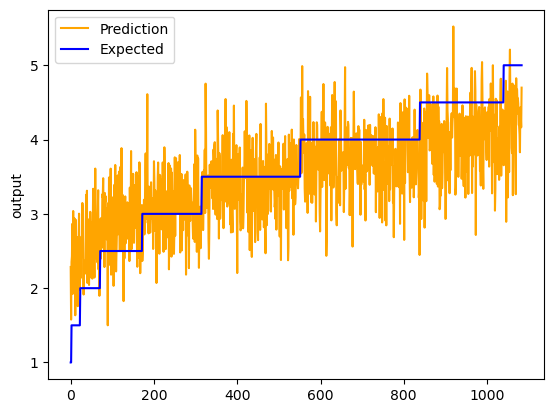

In [9]:
# Author: Nicolas Gugliemo 
# Date: 9/16/2024
# Project: Project 1 Yelp Business Rating Prediction using Tensorflow
# Goal: Predict Business's stars rating... 
# (1) Report the RMSE and plot the lift chart of the BEST neural network model you have obtained.
# (2) Choose 5 arbitrary businesses from your test data (preferably from different categories). Show
#     the names, the true star ratings, and the predicted ratings (from your best model) of those
#     businesses.
# Type: Regression (Expect a number)
# Data Restrictions:
# (1) Businesses with at least 20 reviews
# (2) At least 10K businesses in set
# (3) Business = busisness_id, stars, review_count, categories
# (4) Review   = busisness_id, stars, text 
'''Grading:  (5 pts) Do train/test split.
 (5 pts) Remove all the businesses with less than 20 reviews.
 (10 pts) Use TF-IDF to do feature extraction from review texts.
 (10 pts) Use EarlyStopping when using Tensorflow.
 (30 pts) Change the following hyperparameters to record how they affect performance in your report.
Tabulate your findings.
o Activation: relu, sigmoid, tanh
o Layers and neuron counts
o Optimizer: adam and sgd
 (10 pts) Report the RMSE of the BEST regression model you obtained
 (10 pts) Plot the lift chart on test data of the BEST regression model you obtained
 (5 pts) Show names and the true ratings of 5 businesses, and their predicted ratings
 (5 pts) Your report includes the following sections:
o Problem Statement
o Methodology
o Experimental Results and Analysis
o Task Division and Project Reflection
 (10 pts) Additional features
'''
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

# Set path and preprocess for functions
path = "./yelp_dataset/"
preprocess = True

#Set paths for JSON
review_Path = os.path.join(path,"yelp_academic_dataset_review.json")
business_Path = os.path.join(path,"yelp_academic_dataset_business.json")

# Read JSON data and drop businesses with less than 20 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df = pd.read_json(business_Path, lines=True, nrows = 100000)
business_df = all_business_df[all_business_df['review_count'] >= 20]

#You may use the following code to group ALL the reviews by each business and create a new
#dataframe, where each line is a business with all its reviews aggregated together. From there,
#you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

#Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, df_ready_to_be_sent_to_sklearn, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

#Run the model 5 times to ensure best model is found
i = 0
while (i<5):
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) 
    model.add(Dropout(0.1))
    model.add(Dense(25, input_dim=x.shape[1], activation='relu')) 
    model.add(Dense(1, activation='linear'))

    adam = optimizers.Adam(learning_rate=0.001, beta_1=0.999, beta_2=0.999, epsilon=None, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="dnn/yelp.keras", verbose=0, save_best_only=True) # save best model

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 32, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
    i = i+1

model.load_weights('dnn/yelp.keras') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
print(pred)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))


# Plot the chart
chart_regression(pred.flatten(),y_test)


REG


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 7s - 53ms/step - loss: 2.7947 - val_loss: 0.4910
Epoch 2/1000
136/136 - 1s - 10ms/step - loss: 0.5283 - val_loss: 0.3836
Epoch 3/1000
136/136 - 1s - 10ms/step - loss: 0.3876 - val_loss: 0.3608
Epoch 4/1000
136/136 - 1s - 10ms/step - loss: 0.3498 - val_loss: 0.3758
Epoch 5/1000
136/136 - 1s - 9ms/step - loss: 0.3135 - val_loss: 0.3975
Epoch 6/1000
136/136 - 1s - 9ms/step - loss: 0.2924 - val_loss: 0.4028
Epoch 7/1000
136/136 - 1s - 10ms/step - loss: 0.2695 - val_loss: 0.3957
Epoch 8/1000
136/136 - 1s - 9ms/step - loss: 0.2522 - val_loss: 0.3985
Epoch 9/1000
136/136 - 1s - 9ms/step - loss: 0.2246 - val_loss: 0.3993
Epoch 10/1000
136/136 - 1s - 9ms/step - loss: 0.2222 - val_loss: 0.4000
Epoch 11/1000
136/136 - 1s - 10ms/step - loss: 0.2160 - val_loss: 0.4098
Epoch 12/1000
136/136 - 1s - 9ms/step - loss: 0.2039 - val_loss: 0.4002
Epoch 13/1000
136/136 - 1s - 11ms/step - loss: 0.1986 - val_loss: 0.3849
Epoch 13: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
[[

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 4s - 27ms/step - loss: 1.4453 - val_loss: 0.6101
Epoch 2/1000
136/136 - 1s - 9ms/step - loss: 0.7671 - val_loss: 0.5690
Epoch 3/1000
136/136 - 1s - 9ms/step - loss: 0.6891 - val_loss: 0.5255
Epoch 4/1000
136/136 - 1s - 9ms/step - loss: 0.5983 - val_loss: 0.4416
Epoch 5/1000
136/136 - 1s - 9ms/step - loss: 0.5296 - val_loss: 0.3780
Epoch 6/1000
136/136 - 1s - 9ms/step - loss: 0.4584 - val_loss: 0.3753
Epoch 7/1000
136/136 - 1s - 9ms/step - loss: 0.4217 - val_loss: 0.3344
Epoch 8/1000
136/136 - 1s - 10ms/step - loss: 0.3962 - val_loss: 0.3151
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.3824 - val_loss: 0.3228
Epoch 10/1000
136/136 - 1s - 9ms/step - loss: 0.3582 - val_loss: 0.3029
Epoch 11/1000
136/136 - 1s - 8ms/step - loss: 0.3501 - val_loss: 0.3275
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.3355 - val_loss: 0.3067
Epoch 13/1000
136/136 - 1s - 11ms/step - loss: 0.3190 - val_loss: 0.3032
Epoch 14/1000
136/136 - 2s - 17ms/step - loss: 0.2973 - val_loss: 0.29

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 8s - 55ms/step - loss: 2.1877 - val_loss: 0.3847
Epoch 2/1000
136/136 - 2s - 12ms/step - loss: 0.4653 - val_loss: 0.4425
Epoch 3/1000
136/136 - 2s - 11ms/step - loss: 0.3623 - val_loss: 0.3914
Epoch 4/1000
136/136 - 2s - 15ms/step - loss: 0.2919 - val_loss: 0.4001
Epoch 5/1000
136/136 - 2s - 11ms/step - loss: 0.2765 - val_loss: 0.3900
Epoch 6/1000
136/136 - 2s - 11ms/step - loss: 0.2373 - val_loss: 0.4060
Epoch 7/1000
136/136 - 2s - 17ms/step - loss: 0.2240 - val_loss: 0.4120
Epoch 8/1000
136/136 - 2s - 12ms/step - loss: 0.2046 - val_loss: 0.3918
Epoch 9/1000
136/136 - 2s - 12ms/step - loss: 0.1999 - val_loss: 0.3954
Epoch 10/1000
136/136 - 2s - 17ms/step - loss: 0.1869 - val_loss: 0.3881
Epoch 11/1000
136/136 - 1s - 11ms/step - loss: 0.1742 - val_loss: 0.3861
Epoch 11: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[[2.634336 ]
 [3.2787666]
 [2.6083188]
 ...
 [4.573029 ]
 [3.4134197]
 [3.6717916]]
Score (RMSE): 0.6202144622802734


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 4s - 27ms/step - loss: 1.5257 - val_loss: 0.6166
Epoch 2/1000
136/136 - 1s - 11ms/step - loss: 0.7612 - val_loss: 0.5772
Epoch 3/1000
136/136 - 3s - 20ms/step - loss: 0.7005 - val_loss: 0.5349
Epoch 4/1000
136/136 - 1s - 11ms/step - loss: 0.6247 - val_loss: 0.4683
Epoch 5/1000
136/136 - 1s - 11ms/step - loss: 0.5398 - val_loss: 0.3986
Epoch 6/1000
136/136 - 3s - 19ms/step - loss: 0.4660 - val_loss: 0.3517
Epoch 7/1000
136/136 - 1s - 9ms/step - loss: 0.4144 - val_loss: 0.3306
Epoch 8/1000
136/136 - 1s - 9ms/step - loss: 0.4004 - val_loss: 0.3238
Epoch 9/1000
136/136 - 1s - 9ms/step - loss: 0.3764 - val_loss: 0.3137
Epoch 10/1000
136/136 - 1s - 9ms/step - loss: 0.3557 - val_loss: 0.3048
Epoch 11/1000
136/136 - 1s - 9ms/step - loss: 0.3487 - val_loss: 0.3046
Epoch 12/1000
136/136 - 1s - 8ms/step - loss: 0.3336 - val_loss: 0.3007
Epoch 13/1000
136/136 - 1s - 8ms/step - loss: 0.3159 - val_loss: 0.3362
Epoch 14/1000
136/136 - 1s - 9ms/step - loss: 0.3113 - val_loss: 0.

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 5s - 36ms/step - loss: 2.2349 - val_loss: 0.3907
Epoch 2/1000
136/136 - 2s - 12ms/step - loss: 0.3719 - val_loss: 0.3761
Epoch 3/1000
136/136 - 1s - 11ms/step - loss: 0.2643 - val_loss: 0.3686
Epoch 4/1000
136/136 - 2s - 15ms/step - loss: 0.2157 - val_loss: 0.3628
Epoch 5/1000
136/136 - 2s - 17ms/step - loss: 0.1828 - val_loss: 0.3804
Epoch 6/1000
136/136 - 2s - 13ms/step - loss: 0.1574 - val_loss: 0.3938
Epoch 7/1000
136/136 - 1s - 8ms/step - loss: 0.1409 - val_loss: 0.3969
Epoch 8/1000
136/136 - 1s - 8ms/step - loss: 0.1269 - val_loss: 0.4025
Epoch 9/1000
136/136 - 1s - 7ms/step - loss: 0.1264 - val_loss: 0.4046
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.1204 - val_loss: 0.3930
Epoch 11/1000
136/136 - 1s - 8ms/step - loss: 0.1123 - val_loss: 0.3886
Epoch 12/1000
136/136 - 1s - 8ms/step - loss: 0.1064 - val_loss: 0.3901
Epoch 13/1000
136/136 - 1s - 7ms/step - loss: 0.0978 - val_loss: 0.3921
Epoch 14/1000
136/136 - 1s - 7ms/step - loss: 0.0936 - val_loss: 0.3788
Epoch 14

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 2s - 16ms/step - loss: 1.4344 - val_loss: 0.6250
Epoch 2/1000
136/136 - 1s - 6ms/step - loss: 0.7062 - val_loss: 0.5925
Epoch 3/1000
136/136 - 1s - 6ms/step - loss: 0.6587 - val_loss: 0.5913
Epoch 4/1000
136/136 - 1s - 6ms/step - loss: 0.6123 - val_loss: 0.5098
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.5250 - val_loss: 0.4296
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.4541 - val_loss: 0.3649
Epoch 7/1000
136/136 - 1s - 6ms/step - loss: 0.4032 - val_loss: 0.3525
Epoch 8/1000
136/136 - 1s - 6ms/step - loss: 0.3709 - val_loss: 0.3785
Epoch 9/1000
136/136 - 1s - 6ms/step - loss: 0.3572 - val_loss: 0.3149
Epoch 10/1000
136/136 - 1s - 5ms/step - loss: 0.3308 - val_loss: 0.3050
Epoch 11/1000
136/136 - 1s - 6ms/step - loss: 0.3159 - val_loss: 0.5742
Epoch 12/1000
136/136 - 1s - 6ms/step - loss: 0.3114 - val_loss: 0.2932
Epoch 13/1000
136/136 - 1s - 6ms/step - loss: 0.2957 - val_loss: 0.2924
Epoch 14/1000
136/136 - 1s - 5ms/step - loss: 0.2805 - val_loss: 0.3514
Epoch 15/1000

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 - 4s - 29ms/step - loss: 4.4733 - val_loss: 0.9069
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.9445 - val_loss: 0.6543
Epoch 3/1000
136/136 - 1s - 8ms/step - loss: 0.8510 - val_loss: 0.6460
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.8497 - val_loss: 0.6444
Epoch 5/1000
136/136 - 1s - 7ms/step - loss: 0.8577 - val_loss: 0.6459
Epoch 6/1000
136/136 - 1s - 10ms/step - loss: 0.8580 - val_loss: 0.6431
Epoch 7/1000
136/136 - 1s - 10ms/step - loss: 0.8433 - val_loss: 0.6418
Epoch 8/1000
136/136 - 1s - 10ms/step - loss: 0.8504 - val_loss: 0.6379
Epoch 9/1000
136/136 - 2s - 12ms/step - loss: 0.8349 - val_loss: 0.6340
Epoch 10/1000
136/136 - 2s - 12ms/step - loss: 0.8078 - val_loss: 0.6060
Epoch 11/1000
136/136 - 1s - 11ms/step - loss: 0.7236 - val_loss: 0.4866
Epoch 12/1000
136/136 - 1s - 10ms/step - loss: 0.5381 - val_loss: 0.3361
Epoch 13/1000
136/136 - 1s - 10ms/step - loss: 0.4404 - val_loss: 0.3122
Epoch 14/1000
136/136 - 1s - 11ms/step - loss: 0.3857 - val_loss: 0.2978
Epoc

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 3s - 23ms/step - loss: 1.3423 - val_loss: 0.6470
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.8093 - val_loss: 0.6457
Epoch 3/1000
136/136 - 1s - 8ms/step - loss: 0.7972 - val_loss: 0.6628
Epoch 4/1000
136/136 - 1s - 7ms/step - loss: 0.7762 - val_loss: 0.6494
Epoch 5/1000
136/136 - 1s - 10ms/step - loss: 0.7651 - val_loss: 0.6474
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.7608 - val_loss: 0.6559
Epoch 7/1000
136/136 - 1s - 8ms/step - loss: 0.7479 - val_loss: 0.6461
Epoch 8/1000
136/136 - 1s - 9ms/step - loss: 0.7382 - val_loss: 0.6465
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.7410 - val_loss: 0.6459
Epoch 10/1000
136/136 - 1s - 8ms/step - loss: 0.7455 - val_loss: 0.6520
Epoch 11/1000
136/136 - 1s - 8ms/step - loss: 0.7424 - val_loss: 0.6499
Epoch 12/1000
136/136 - 1s - 8ms/step - loss: 0.7336 - val_loss: 0.6464
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[[3.6153219]
 [3.614286 ]
 [3.6164217]
 ...
 [3.615947 ]
 [3.6159074]
 [3.61603

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 8s - 56ms/step - loss: 3.2233 - val_loss: 0.7335
Epoch 2/1000
136/136 - 2s - 11ms/step - loss: 0.8526 - val_loss: 0.6469
Epoch 3/1000
136/136 - 2s - 12ms/step - loss: 0.8423 - val_loss: 0.6455
Epoch 4/1000
136/136 - 2s - 12ms/step - loss: 0.8392 - val_loss: 0.6457
Epoch 5/1000
136/136 - 2s - 12ms/step - loss: 0.8377 - val_loss: 0.6456
Epoch 6/1000
136/136 - 2s - 14ms/step - loss: 0.8185 - val_loss: 0.6437
Epoch 7/1000
136/136 - 2s - 12ms/step - loss: 0.8383 - val_loss: 0.6437
Epoch 8/1000
136/136 - 2s - 14ms/step - loss: 0.8111 - val_loss: 0.6400
Epoch 9/1000
136/136 - 2s - 12ms/step - loss: 0.8116 - val_loss: 0.6266
Epoch 10/1000
136/136 - 2s - 11ms/step - loss: 0.7610 - val_loss: 0.5563
Epoch 11/1000
136/136 - 2s - 12ms/step - loss: 0.6127 - val_loss: 0.3580
Epoch 12/1000
136/136 - 2s - 11ms/step - loss: 0.4370 - val_loss: 0.3091
Epoch 13/1000
136/136 - 2s - 12ms/step - loss: 0.3833 - val_loss: 0.2988
Epoch 14/1000
136/136 - 2s - 12ms/step - loss: 0.3556 - val_

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 3s - 23ms/step - loss: 1.1098 - val_loss: 0.6460
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.8009 - val_loss: 0.6463
Epoch 3/1000
136/136 - 1s - 8ms/step - loss: 0.7960 - val_loss: 0.6467
Epoch 4/1000
136/136 - 1s - 9ms/step - loss: 0.7716 - val_loss: 0.6664
Epoch 5/1000
136/136 - 1s - 9ms/step - loss: 0.7758 - val_loss: 0.6511
Epoch 6/1000
136/136 - 1s - 8ms/step - loss: 0.7619 - val_loss: 0.6465
Epoch 7/1000
136/136 - 1s - 8ms/step - loss: 0.7583 - val_loss: 0.6532
Epoch 8/1000
136/136 - 1s - 9ms/step - loss: 0.7512 - val_loss: 0.6457
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.7442 - val_loss: 0.6525
Epoch 10/1000
136/136 - 1s - 8ms/step - loss: 0.7333 - val_loss: 0.6464
Epoch 11/1000
136/136 - 1s - 9ms/step - loss: 0.7355 - val_loss: 0.6501
Epoch 11: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[[3.6180012]
 [3.6187289]
 [3.6177888]
 ...
 [3.6184568]
 [3.6183243]
 [3.6190355]]
Score (RMSE): 0.8035551905632019


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 9s - 67ms/step - loss: 1.4386 - val_loss: 0.6356
Epoch 2/1000
136/136 - 1s - 10ms/step - loss: 0.7416 - val_loss: 0.6194
Epoch 3/1000
136/136 - 1s - 10ms/step - loss: 0.6866 - val_loss: 0.5053
Epoch 4/1000
136/136 - 2s - 11ms/step - loss: 0.4948 - val_loss: 0.3336
Epoch 5/1000
136/136 - 1s - 10ms/step - loss: 0.3800 - val_loss: 0.3044
Epoch 6/1000
136/136 - 2s - 11ms/step - loss: 0.3288 - val_loss: 0.2928
Epoch 7/1000
136/136 - 1s - 10ms/step - loss: 0.3127 - val_loss: 0.2966
Epoch 8/1000
136/136 - 1s - 10ms/step - loss: 0.2920 - val_loss: 0.2851
Epoch 9/1000
136/136 - 1s - 9ms/step - loss: 0.2628 - val_loss: 0.2913
Epoch 10/1000
136/136 - 1s - 9ms/step - loss: 0.2545 - val_loss: 0.2879
Epoch 11/1000
136/136 - 1s - 9ms/step - loss: 0.2434 - val_loss: 0.2896
Epoch 12/1000
136/136 - 1s - 10ms/step - loss: 0.2310 - val_loss: 0.2963
Epoch 13/1000
136/136 - 1s - 9ms/step - loss: 0.2269 - val_loss: 0.2959
Epoch 14/1000
136/136 - 1s - 9ms/step - loss: 0.2105 - val_loss:

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 3s - 24ms/step - loss: 0.9436 - val_loss: 0.7392
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.7666 - val_loss: 0.6597
Epoch 3/1000
136/136 - 1s - 8ms/step - loss: 0.7613 - val_loss: 0.7221
Epoch 4/1000
136/136 - 1s - 8ms/step - loss: 0.7599 - val_loss: 0.6711
Epoch 5/1000
136/136 - 1s - 8ms/step - loss: 0.7435 - val_loss: 0.6629
Epoch 6/1000
136/136 - 1s - 9ms/step - loss: 0.7448 - val_loss: 0.6499
Epoch 7/1000
136/136 - 1s - 8ms/step - loss: 0.7296 - val_loss: 0.6796
Epoch 8/1000
136/136 - 1s - 8ms/step - loss: 0.7371 - val_loss: 0.6651
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.7353 - val_loss: 0.6469
Epoch 10/1000
136/136 - 1s - 8ms/step - loss: 0.7316 - val_loss: 0.6737
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.7255 - val_loss: 0.7341
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.7191 - val_loss: 0.6915
Epoch 13/1000
136/136 - 1s - 8ms/step - loss: 0.7203 - val_loss: 0.6647
Epoch 14/1000
136/136 - 1s - 8ms/step - loss: 0.7263 - val_loss: 0.6471


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 8s - 57ms/step - loss: 1.3926 - val_loss: 0.4113
Epoch 2/1000
136/136 - 1s - 10ms/step - loss: 0.4232 - val_loss: 0.3345
Epoch 3/1000
136/136 - 1s - 10ms/step - loss: 0.3241 - val_loss: 0.3037
Epoch 4/1000
136/136 - 1s - 10ms/step - loss: 0.2861 - val_loss: 0.3077
Epoch 5/1000
136/136 - 1s - 9ms/step - loss: 0.2500 - val_loss: 0.3367
Epoch 6/1000
136/136 - 1s - 9ms/step - loss: 0.2379 - val_loss: 0.3550
Epoch 7/1000
136/136 - 1s - 10ms/step - loss: 0.2126 - val_loss: 0.3783
Epoch 8/1000
136/136 - 1s - 9ms/step - loss: 0.1947 - val_loss: 0.3969
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.1885 - val_loss: 0.4094
Epoch 10/1000
136/136 - 1s - 9ms/step - loss: 0.1816 - val_loss: 0.3984
Epoch 11/1000
136/136 - 1s - 9ms/step - loss: 0.1655 - val_loss: 0.4013
Epoch 12/1000
136/136 - 1s - 9ms/step - loss: 0.1629 - val_loss: 0.4165
Epoch 13/1000
136/136 - 1s - 9ms/step - loss: 0.1574 - val_loss: 0.4175
Epoch 13: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
[[2.

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 3s - 23ms/step - loss: 0.9995 - val_loss: 0.6061
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.7018 - val_loss: 0.5249
Epoch 3/1000
136/136 - 1s - 8ms/step - loss: 0.5955 - val_loss: 0.4336
Epoch 4/1000
136/136 - 1s - 8ms/step - loss: 0.4773 - val_loss: 0.3802
Epoch 5/1000
136/136 - 1s - 8ms/step - loss: 0.4194 - val_loss: 0.3266
Epoch 6/1000
136/136 - 1s - 7ms/step - loss: 0.3801 - val_loss: 0.3459
Epoch 7/1000
136/136 - 1s - 8ms/step - loss: 0.3457 - val_loss: 0.3116
Epoch 8/1000
136/136 - 1s - 7ms/step - loss: 0.3370 - val_loss: 0.3212
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.3134 - val_loss: 0.2987
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.3141 - val_loss: 0.3097
Epoch 11/1000
136/136 - 1s - 7ms/step - loss: 0.2913 - val_loss: 0.3038
Epoch 12/1000
136/136 - 1s - 7ms/step - loss: 0.2774 - val_loss: 0.3088
Epoch 13/1000
136/136 - 1s - 7ms/step - loss: 0.2690 - val_loss: 0.3467
Epoch 14/1000
136/136 - 1s - 8ms/step - loss: 0.2708 - val_loss: 0.3623


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 8s - 59ms/step - loss: 1.5046 - val_loss: 0.6125
Epoch 2/1000
136/136 - 2s - 12ms/step - loss: 0.5426 - val_loss: 0.3153
Epoch 3/1000
136/136 - 2s - 12ms/step - loss: 0.3185 - val_loss: 0.3090
Epoch 4/1000
136/136 - 1s - 11ms/step - loss: 0.2593 - val_loss: 0.3338
Epoch 5/1000
136/136 - 1s - 10ms/step - loss: 0.2278 - val_loss: 0.3434
Epoch 6/1000
136/136 - 1s - 11ms/step - loss: 0.2082 - val_loss: 0.3551
Epoch 7/1000
136/136 - 1s - 11ms/step - loss: 0.1971 - val_loss: 0.3775
Epoch 8/1000
136/136 - 1s - 10ms/step - loss: 0.1748 - val_loss: 0.3818
Epoch 9/1000
136/136 - 1s - 10ms/step - loss: 0.1650 - val_loss: 0.3794
Epoch 10/1000
136/136 - 1s - 10ms/step - loss: 0.1614 - val_loss: 0.3957
Epoch 11/1000
136/136 - 1s - 10ms/step - loss: 0.1448 - val_loss: 0.4109
Epoch 12/1000
136/136 - 1s - 10ms/step - loss: 0.1469 - val_loss: 0.4143
Epoch 13/1000
136/136 - 1s - 10ms/step - loss: 0.1404 - val_loss: 0.4165
Epoch 13: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/s

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 3s - 24ms/step - loss: 1.0440 - val_loss: 0.6159
Epoch 2/1000
136/136 - 1s - 9ms/step - loss: 0.7063 - val_loss: 0.5594
Epoch 3/1000
136/136 - 1s - 9ms/step - loss: 0.6195 - val_loss: 0.4945
Epoch 4/1000
136/136 - 1s - 9ms/step - loss: 0.4981 - val_loss: 0.4040
Epoch 5/1000
136/136 - 1s - 8ms/step - loss: 0.4288 - val_loss: 0.3387
Epoch 6/1000
136/136 - 1s - 8ms/step - loss: 0.3853 - val_loss: 0.3480
Epoch 7/1000
136/136 - 1s - 9ms/step - loss: 0.3671 - val_loss: 0.3110
Epoch 8/1000
136/136 - 1s - 8ms/step - loss: 0.3353 - val_loss: 0.3523
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.3261 - val_loss: 0.4641
Epoch 10/1000
136/136 - 1s - 8ms/step - loss: 0.3117 - val_loss: 0.2959
Epoch 11/1000
136/136 - 1s - 8ms/step - loss: 0.2998 - val_loss: 0.2954
Epoch 12/1000
136/136 - 1s - 9ms/step - loss: 0.2827 - val_loss: 0.3008
Epoch 13/1000
136/136 - 1s - 8ms/step - loss: 0.2741 - val_loss: 0.3106
Epoch 14/1000
136/136 - 1s - 8ms/step - loss: 0.2610 - val_loss: 0.2959


c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 8s - 56ms/step - loss: 1.4158 - val_loss: 0.3422
Epoch 2/1000
136/136 - 1s - 10ms/step - loss: 0.3244 - val_loss: 0.3120
Epoch 3/1000
136/136 - 1s - 9ms/step - loss: 0.2426 - val_loss: 0.3313
Epoch 4/1000
136/136 - 1s - 10ms/step - loss: 0.2063 - val_loss: 0.3569
Epoch 5/1000
136/136 - 1s - 10ms/step - loss: 0.1840 - val_loss: 0.4141
Epoch 6/1000
136/136 - 1s - 9ms/step - loss: 0.1617 - val_loss: 0.3980
Epoch 7/1000
136/136 - 1s - 10ms/step - loss: 0.1414 - val_loss: 0.4440
Epoch 8/1000
136/136 - 1s - 9ms/step - loss: 0.1323 - val_loss: 0.4334
Epoch 9/1000
136/136 - 1s - 9ms/step - loss: 0.1249 - val_loss: 0.4635
Epoch 10/1000
136/136 - 1s - 9ms/step - loss: 0.1163 - val_loss: 0.4504
Epoch 11/1000
136/136 - 1s - 9ms/step - loss: 0.1029 - val_loss: 0.5252
Epoch 12/1000
136/136 - 1s - 9ms/step - loss: 0.0936 - val_loss: 0.4723
Epoch 12: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
[[2.7906847]
 [3.3315954]
 [2.870802 ]
 ...
 [4.3404174]
 [3.6471305]
 [4.04

c:\Users\dachen\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
136/136 - 5s - 36ms/step - loss: 1.0336 - val_loss: 0.6125
Epoch 2/1000
136/136 - 1s - 8ms/step - loss: 0.6511 - val_loss: 0.5434
Epoch 3/1000
136/136 - 1s - 8ms/step - loss: 0.5681 - val_loss: 0.4709
Epoch 4/1000
136/136 - 1s - 8ms/step - loss: 0.4627 - val_loss: 0.4104
Epoch 5/1000
136/136 - 1s - 8ms/step - loss: 0.3960 - val_loss: 0.3405
Epoch 6/1000
136/136 - 1s - 8ms/step - loss: 0.3508 - val_loss: 0.3256
Epoch 7/1000
136/136 - 1s - 8ms/step - loss: 0.3334 - val_loss: 0.3479
Epoch 8/1000
136/136 - 1s - 8ms/step - loss: 0.3143 - val_loss: 0.3037
Epoch 9/1000
136/136 - 1s - 8ms/step - loss: 0.2982 - val_loss: 0.4798
Epoch 10/1000
136/136 - 1s - 7ms/step - loss: 0.2940 - val_loss: 0.3110
Epoch 11/1000
136/136 - 1s - 8ms/step - loss: 0.2757 - val_loss: 0.2993
Epoch 12/1000
136/136 - 1s - 8ms/step - loss: 0.2663 - val_loss: 0.3104
Epoch 13/1000
136/136 - 1s - 8ms/step - loss: 0.2695 - val_loss: 0.4263
Epoch 14/1000
136/136 - 1s - 8ms/step - loss: 0.2548 - val_loss: 0.3003


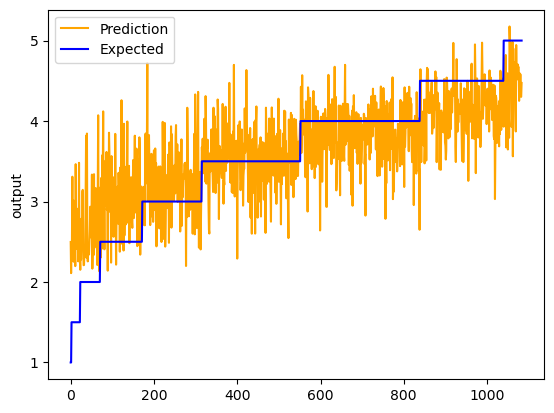

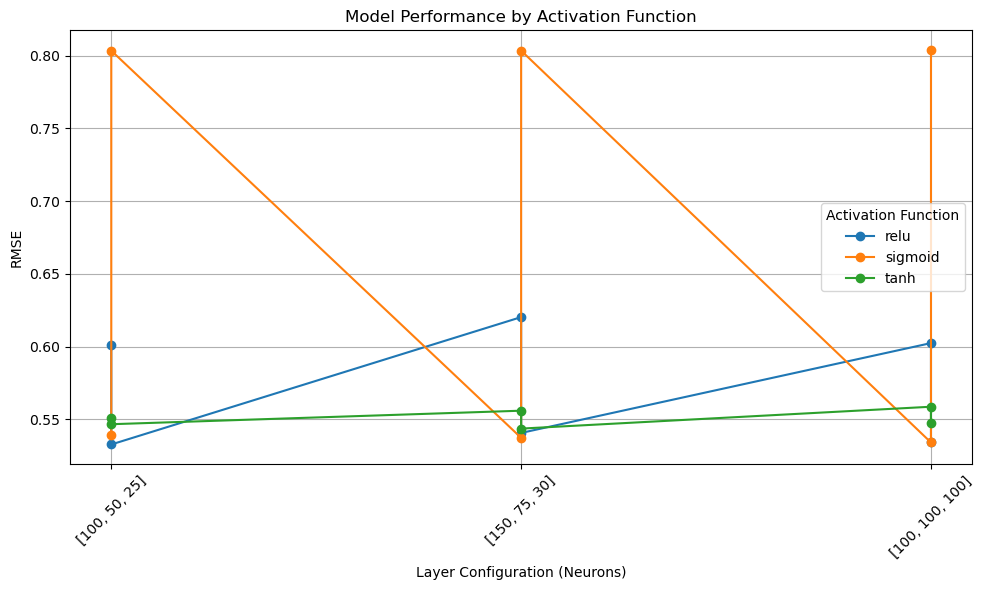

In [10]:
''' 
Tuning the following hyperparameters when training neural networks using Tensorflow and
tabulate all the results of each model on how they affect performance in your report. Also,
save all the models you have tried as a proof in your notebook.
• Activation: relu, sigmoid, tanh
• Number of layers and neuron count for each layer
• Optimizer: adam and sgd. 
'''

from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

model_dir = "models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Set path and preprocess for functions
path = "./yelp_dataset/"

#Set paths for JSON
review_Path = os.path.join(path,"yelp_academic_dataset_review.json")
business_Path = os.path.join(path,"yelp_academic_dataset_business.json")

# Read JSON data and drop businesses with less than 20 reviews
review_df = pd.read_json(review_Path, lines=True, nrows = 100000)
all_business_df = pd.read_json(business_Path, lines=True, nrows = 100000)
business_df = all_business_df[all_business_df['review_count'] >= 20]

#You may use the following code to group ALL the reviews by each business and create a new
#dataframe, where each line is a business with all its reviews aggregated together. From there,
#you then use tfidfVectorzier to obtain TFIDF representation for each business.
df_review_agg = review_df.groupby('business_id')['text'].sum()
df_ready_to_be_sent_to_sklearn = pd.DataFrame({'business_id': df_review_agg.index,
                                               'all_reviews': df_review_agg.values,})

#Create table with ID, stars, and all reviews in one table then change 'stars' since this is already a col on tfidf
business_subset = business_df[['business_id', 'stars']]
review_subset = df_ready_to_be_sent_to_sklearn[['business_id', 'all_reviews']]
merged_df = pd.merge(business_subset, df_ready_to_be_sent_to_sklearn, on='business_id', how='inner')
merged_df.rename(columns={'stars': 'stars_for_model'}, inplace=True)

# Initialize the tfidf Vectorizer and set max features and stop words
tfidf = TfidfVectorizer(max_features=4000,stop_words="english")

# Transform all_reviews and turn into a matrix
tfidf_matrix = tfidf.fit_transform(merged_df['all_reviews'])

# Turn the matrix into a dataframe where the cols are all the words. Then add the stars into the dataframe for model to use and use to_xy for tensorflow to read
tfidf_df = pd.DataFrame(data = tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
tfidf_df = pd.concat([merged_df['stars_for_model'], tfidf_df] , axis=1)
x,y = to_xy(tfidf_df,'stars_for_model')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Define hyperparameters that were requested
activations = ['relu', 'sigmoid', 'tanh']
layer_neurons = [[100, 50, 25], [150, 75, 30], [100, 100, 100]]  # Different layer configurations
optimizers = ['adam', 'sgd']

def Model_Test(activation, layer_neurons, optimizer):
    model = Sequential()
    model.add(Dense(layer_neurons[0], input_dim=x_train.shape[1], activation=activation))
    model.add(Dropout(0.1))
    for n in layer_neurons[1:]:
        model.add(Dense(n, activation=activation))
        model.add(Dropout(0.1))
    model.add(Dense(1, activation ='linear'))
    model.compile(loss='mean_squared_error', optimizer = optimizer)
    return model

best_rmse = float('inf')
best_model = None
best_params = {}

results = []

for activation in activations:
    for neurons in layer_neurons:
        for optimizer in optimizers:
            model = Model_Test(activation, neurons, optimizer)

            #
            monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
            model_filename = f"model_{activation}_{neurons}_{optimizer}.keras"
            checkpointer = ModelCheckpoint(filepath=model_filename, verbose=0, save_best_only=True) # save best model

            # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
            model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 32, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)

            #
            model.load_weights(model_filename)

            # Predict and measure RMSE
            pred = model.predict(x_test)
            print(pred)
            score = np.sqrt(metrics.mean_squared_error(pred,y_test))
            print("Score (RMSE): {}".format(score))

            # Store results
            results.append({
                'Activation': activation,
                'Neurons': str(neurons),
                'Optimizer': optimizer,
                'RMSE': score
            })

            if score < best_rmse:
                best_rmse = score
                best_model = model
                best_params = {
                    'Activation': activation,
                    'Neurons': neurons,
                    'Optimizer': optimizer,
                    'RMSE': best_rmse
                }

# Table of Results
results_df = pd.DataFrame(results)
print(results_df)

print("\nBest Combination:")
print(best_params)

# Plot the chart
pred = best_model.predict(x_test)
chart_regression(pred.flatten(), y_test)

plot(results_df)